# Example: 1D Oscillator - Part 1/4

- Author: Dr. Daning Huang
- Date: 07/14/2025
- Updated: 12/08/2025

In [1]:
# Some basic imports
import numpy as np
import torch
# We will import relevant DyMAD components along the way

## Introduction

This notebook explains the typical workflow of `DyMAD`, including
- Data preparation
- Case definition
- Model training
- Post-processing

## Data Preparation

`DyMAD` currently accept trajectory data containing the following:

- Time of size $(B,N)$
- Input of size $(B,N,U)$
- Output of size $(B,N,X)$

where $B$ is batch size, $N$ is trajectory length, $U$ is input dimension, and $X$ is output dimension.

> Note that we use the convention in autoencoders, so the states are $z$.

While in practice one might already got the dataset from elsewhere, here to make the example self-contained, we generate some data ourselves.

This uses the following `DyMAD` components:

In [2]:
from dymad.utils import plot_trajectory, plot_multi_trajs, TrajectorySampler

First let's define data specifications and the dynamics.  To make the training overhead minimal, let's consider a simple linear oscillator model with damping and inputs.

$$
\begin{align*}
\dot{z} &= \begin{bmatrix} 0 & 1 \\ -1 & -0.1 \end{bmatrix}z + \begin{bmatrix} 1 \\ 1 \end{bmatrix}u \\
x &= z
\end{align*}
$$

In [3]:
B = 128   # Number of trajectories
N = 501   # Number of steps
t_grid = np.linspace(0, 5, N)

A = np.array([
            [0., 1.],
            [-1., -0.1]])
def f(t, z, u):               # Define the dynamics
    return (z @ A.T) + u
g = lambda t, z, u: z         # Define the observation

Next, to sample the trajectories, we need to determine how the initial conditions and the inputs are sampled, and how is the ODE solved.

The options are supplied through a YAML file with possibly modifications from a Python dictionary.

> We choose YAML files to be compatible with servers, which usually operate in a file-based manner.

The YAML file for this example, `lti_data.yaml`, is defined as follows, which should be self-explanatory,

- dims: Define the dimensions
- x0: Define the sampling for initial conditions - here it is random uniform over a square domain $[-1,1]^2$.
- solver: Define the ODE solver - here it is standard RK45 from SciPy.

In [ ]:
"""
dims:
  states: 2
  inputs: 1
  observations: 2

x0:
  kind: uniform
  params:
    bounds:
      - -1.0
      - 1.0

solver:
  method: RK45
  rtol: 1.0e-6
  atol: 1.0e-6
"""

To illustrate the dictionary-based functionality, we define the control inputs as follows, which are

- Random chirp inputs
- Ends at 4 (so fixed frequency between 4 and 5 time units)
- Ranges of frequencies, amplitudes, and phases are defined by tuples.

In [5]:
config_chr = {
    "control" : {
        "kind": "chirp",
        "params": {
            "t1": 4.0,
            "freq_range": (0.5, 2.0),
            "amp_range": (0.5, 1.0),
            "phase_range": (0.0, 360.0)}}}

With everything defined, we generate the data.

In [6]:
sampler = TrajectorySampler(f, g, config='lti_data.yaml', config_mod=config_chr)
ts, zs, us, xs = sampler.sample(t_grid, batch=B, save='./data/lti.npz')

To verify the solution, we can plot one of the trajectories.  Here we use a built-in function in `DyMAD`, which will be used later for model comparisons.  One could also use another built-in function that plots multiple trajectories.

array([<Axes: ylabel='State 1'>, <Axes: ylabel='State 2'>,
       <Axes: xlabel='Time', ylabel='Control 1'>], dtype=object)

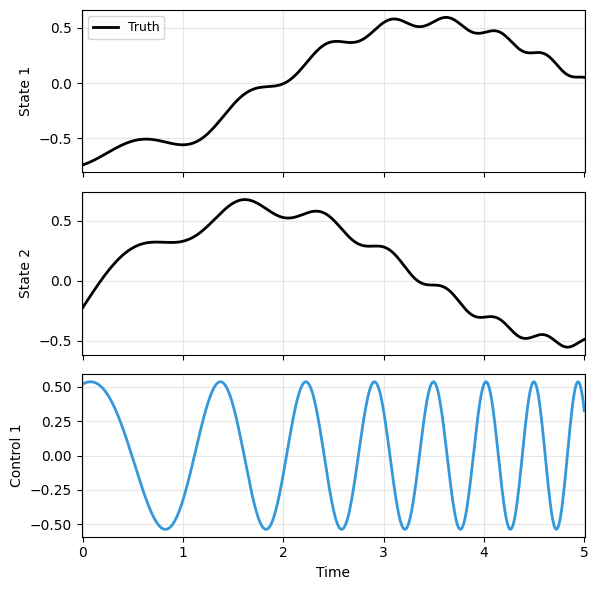

In [7]:
plot_trajectory(
    np.array([xs[0]]), ts[0], "sample",
    us=us[0], labels=['Truth'], ifclose=False)

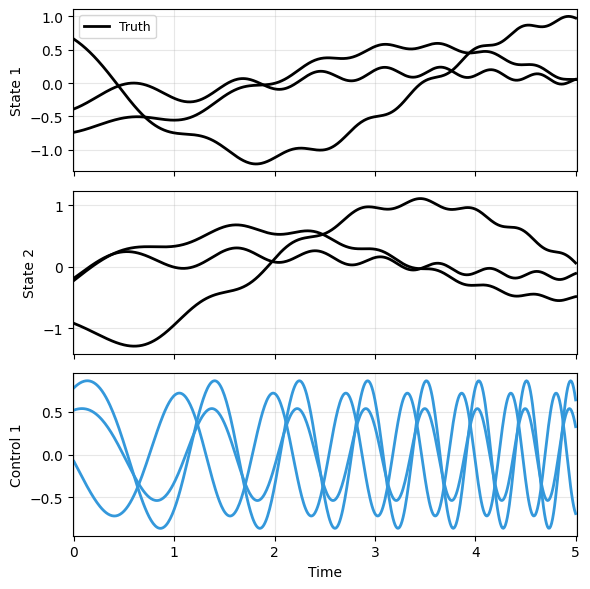

In [8]:
plot_multi_trajs(
    np.array([xs[:3]]), ts[0], "sample",
    us=us[:3], labels=['Truth'], ifclose=False)

## Case Definition

Next let's define the model.  To start with, let's use a standard latent dynamics model,

$$
\begin{align*}
z &= h(x, u) \\
\dot{z} &= f(z, u) \\
x &= g(z, u)
\end{align*}
$$

where $h$ and $g$ are encoder and decoder, respectively, and $f$ is dynamics.

We use a YAML file, `lti_model.yaml`, to define the model and all other training details.

Let's break it into three parts and walk them through.

The first part should be self-explanatory - just note that we are not normalizing data in this very initial example.

In [ ]:
"""
data:          # With dimensions to cross-check
  path: './data/lti.npz'
  n_samples: 128
  n_steps: 501
  double_precision: false

transform_x:   # Use observation data as is
  type: "identity"

transform_u:   # Use input data as is
  type: "identity"

split:         # Train-valid-test split; valid:test=1:1
  train_frac: 0.75

dataloader:
  batch_size: 64
"""

Next, the model.  The main thing to note is that the model is significantly simplified since we know the data is from a linear system.

Meanwhile, cubic interpolation is assumed for the continuous-time model.  The input data is provided at discretize time points, and interpolation is needed during the ODE solve.

In [ ]:
"""
model:
  name: 'lti_ldm_node'
  encoder_layers: 0
  processor_layers: 1
  decoder_layers: 0
  latent_dimension: 32
  activation: "none"
  weight_init: "xavier_uniform"
  input_order: "cubic"
"""

The last part is the training.  Here the standard Neural ODE solver is used, and most of the options should be self-explanatory.

The only specific options are `sweep_lengths` and `sweep_epoch_step`.  This defines a sweeping scheme to accelerate the NODE training.  In the given parameters, the optimizer will start with only the first $H=50$ time steps of data to evaluate the loss and train the model.  After 100 epochs, $H$ increases to 100, then 200, and so forth.

In [ ]:
"""
training:
  n_epochs: 500
  save_interval: 10
  load_checkpoint: false
  learning_rate: 1e-3
  decay_rate: 0.999
  # NODE-specific parameters
  sweep_lengths: [50, 100, 200, 300, 501]
  sweep_epoch_step: 100
  ode_method: 'dopri5'
  ode_args:
    rtol: 1.e-7
    atol: 1.e-9
"""

## Model Training

Next, let's import the following:

In [12]:
from dymad.models import LDM
from dymad.training import NODETrainer

... and start the training.

The training process is tracked in the folder `lti_model`, i.e., the same name as the YAML file.  It includes at least a subfolder `_c0_f0`, consisting of

- A log file of model construction, loss history, etc.
- Plots of model predictions that are regularly evaluated on the dataset during the training, to help assess the model performance on the fly.
- Plots of loss history, where the test loss is included as well - but it is not used to select model, and only for monitoring purpose.
- Checkpoints of the intermediate models.
- A file of training histories.

After the training is done, the checkpoint of the best model is copied to `lti_model`.

> You might be curious what would be `_c1_f0`, `_c1_f1`, etc.  These will be discussed in Part 4 when we have the parametric sweep study.

The notebook or the command line (if using .py script) will not have any outputs.  This design is again to align with usage on servers, where graphic interface might not be available.

In [ ]:
config_path = 'lti_model.yaml'
trainer = NODETrainer(config_path, LDM)
trainer.train();

## Post-Processing

Once the model is trained, we pre-build two ways to assess the training.

### Training History

The first plot is the history of losses, which are saved in `lti_ldm_node/lti_ldm_node_summary.npz`.  The training loss is the objective to be minimized during training, while prediction criterion is the trajectory error evaluated using the model during training.

The two losses are usually different.  One is that their mathematical definitions are different, e.g., in the weak form optimizer.  The other is that the prediction criterion is typically only evaluated for a random trajectory to save computational cost, while the training loss is for the entire (training) dataset.

Note that in the plot below, the loss has several jumps in the middle.  This is due to the sweeping scheme, when the prediction horizon changes.  Meanwhile, the prediction criterion is always evaluated over the full trajectory.

> In this setup, the loss has not reduced too much, so we would not expect the model prediction to be accurate.

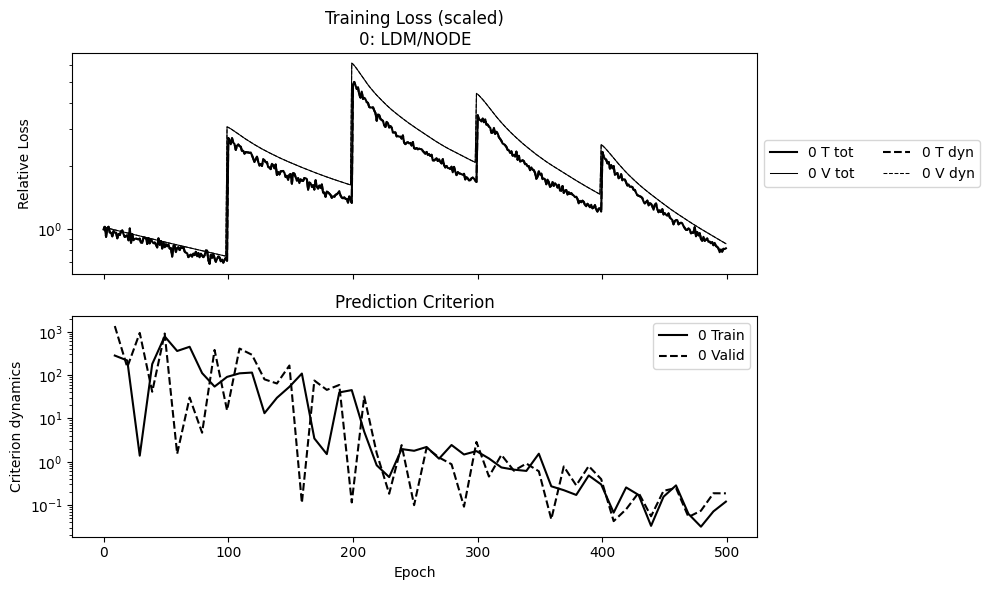

In [14]:
from dymad.utils import plot_summary
npz = ['lti_ldm_node']
plot_summary(npz, labels = ['LDM/NODE'], ifclose=False);

### Model Prediction

The second plot is to make model predictions and compare against truth.

We make it more interesting using trajectories with entirely different control inputs - random Gaussian in this case.

In [15]:
config_gau = {
    "control" : {
        "kind": "gaussian",
        "params": {
            "mean": 0.5,
            "std":  1.0,
            "t1":   4.0,
            "dt":   0.2,
            "mode": "zoh"}}}
sampler = TrajectorySampler(f, g, config='lti_data.yaml', config_mod=config_gau)

ts, xs, us, ys = sampler.sample(t_grid, batch=1, save=None)
x_data = xs[0]
t_data = ts[0]
u_data = us[0]

Next we load the model, which generates a handy function for prediction.

In [17]:
from dymad.io import load_model
mdl_nd, prd_nd = load_model(LDM, 'lti_ldm_node.pt')

Lastly predict, plot, and compare.

> As expected, the prediction is far off

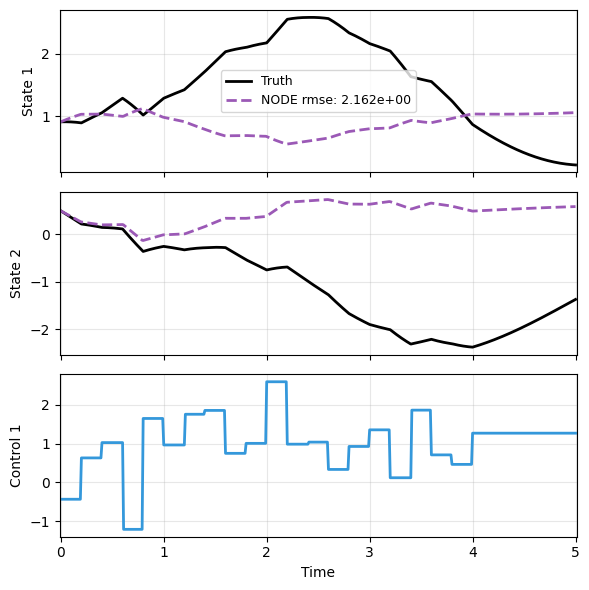

In [19]:
with torch.no_grad():
    node_pred = prd_nd(x_data, t_data, u=u_data)

plot_trajectory(
    np.array([x_data, node_pred]), t_data, "LTI",
    us=u_data, labels=['Truth', 'NODE'], ifclose=False);

While we could tune parameters such as the number of epochs to improve the prediction, in the follow part, we will explore and compare different optimizers and models.